In [10]:
#Setting up the enviroment
%matplotlib inline
import pandas_datareader as web
import matplotlib.pyplot as plt
from datetime import timedelta
import scipy.stats as stats
import datetime as dt
import pandas as pd
import numpy as np
import statistics
import itertools
import math

plt.style.use('dark_background')

In [ ]:
"""
This method gets a DataFrame from the defunct yahoo finance api (it still works, shocking) 
using our data reader
"""
def get_dataframe(ticker, start_date, end_date):
        # Get price data
        price_frame = pd.DataFrame
        try:
            price_frame = web.DataReader(ticker, 'yahoo', start_date, end_date)['Adj Close']
        except Exception:
            print("Error in get_dataframe" + str(Exception))
        return price_frame

In [11]:
#This is the main method where we process the data and run our simulations
def monte_carlo_chart(frame, days_forward, num_sims, ticker):
        green_color_wheel = itertools.cycle(['#73FF73', '#4CFF4C', '#26FF26', '#008C00', '#00B200',
                               '#00D900', '#00FF00', '#00FF00', '#80FF00', '#55FF00',
                               '#2AFF00', '#00FF55', '#00FF2A', '#00FF00', '#00FF00'])
        returns = frame.pct_change().dropna()
        last_price = frame[-1]

        sim_frame = pd.DataFrame()
        daily_vol = returns.std()

        final_prices = []
        #line level
        for i in range(num_sims):
            count = 0
            price_series = []
            price_series.append(last_price)

            #point level
            for j in range(days_forward + 1):
                if count == days_forward:
                    break

                price = price_series[count] * (1 + np.random.normal(0, daily_vol))
                price_series.append(price)
                count += 1

            final_prices.append(price_series[-1])
            sim_frame[i] = price_series

        #Plot data
        color_midline = '#abb7a8'
        color_sigma1_line = '#66ff66'
        color_sigma2 = '#00cc00'
        color_sigma3 = '#006600'
        color_tick = '#739d75'
        color_label = '#acc897'
        color_line = '#244828'
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 3), sharey=True)

        #Monte Carlo plot
        ax1.tick_params(direction='in', length=6, width=2, colors=color_tick, right=True, labelright='on')

        #plots the lines with different shades of green
        for col in sim_frame:
            ax1.plot(sim_frame[col], color=next(green_color_wheel))

        ax1.axhline(y=last_price, color=color_midline, linestyle='--')
        ax1.set_xlabel('Days')
        ax1.set_ylabel('Price')
        title = str(days_forward) + ' day simulation of ' + ticker + ' using ' + str(num_sims) + ' trials'
        ax1.set_title(title, color=color_label)
        ax1.xaxis.label.set_color(color_label)
        ax1.yaxis.label.set_color(color_label)

        #Probability plot
        final_prices.sort()

        # set y limit to 0
        ax1.set_ylim([0, math.ceil(float(final_prices[-1]))])
        ax2.set_ylim([0, math.ceil(float(final_prices[-1]))])

        price_mean = np.mean(final_prices)
        price_standard = np.std(final_prices)
        normalized_df = stats.norm.pdf(final_prices, price_mean, price_standard)
        ax2.tick_params(direction='in', length=6, width=2, colors=color_tick, right=True, labelright='on')
        ax2.plot(normalized_df, final_prices, color=color_sigma1_line)
        ax2.invert_xaxis()

        #calculate the mean of our final price data
        probability_frame = pd.DataFrame(final_prices, normalized_df)
        mean_price = probability_frame.loc[max(normalized_df), :].iloc[0]
        sigma = statistics.pstdev(final_prices)
        ax2.axhline(y = mean_price, color=color_midline, linestyle='--')

        final_prices = np.linspace(mean_price - 4 * sigma, mean_price + 4 * sigma, 200)
        norm_prices = stats.norm.pdf(final_prices, mean_price, sigma)
        plt.plot(norm_prices, final_prices, color=color_line)
        
        #fills the area 1 standard deviations from the mean
        plt.fill_betweenx(final_prices, 0, norm_prices,
                          where=(final_prices >= mean_price - sigma) & (
                                      final_prices <= mean_price + sigma),
                          color=color_sigma1_line, alpha=0.5)
        #fills the area 2 standard deviations from the mean
        plt.fill_betweenx(final_prices, 0, norm_prices, where=(
                                 ((final_prices >= mean_price + sigma) &
                                  (final_prices <= mean_price + 2 * sigma)) |
                                ((final_prices <= mean_price - sigma) &
                                 (final_prices >= mean_price - 2 * sigma))),
                          color=color_sigma2, alpha=0.4)
        
        #fills the area 3 standard deviations from the mean
        plt.fill_betweenx(final_prices, 0, norm_prices,
                          where=(final_prices >= mean_price + 2 * sigma) |
                                (final_prices <= mean_price - 2 * sigma),
                          color=color_sigma3, alpha=0.3)

        #Add standard deviation ticks to our normal distribution chart
        ticks = [(mean_price),(mean_price + sigma),(mean_price - sigma),(mean_price + 2 * sigma),(mean_price - 2 * sigma)]
        ax2.set_yticks(list(ticks))
        
        #label the normal distribution chart (Optional)
        ax2.set_xlabel('Probability')
        ax2.set_ylabel('Price')
        ax2.set_title('Price Probability Distribution ' + ticker, color=color_label)
        ax2.xaxis.label.set_color(color_label)
        ax2.yaxis.label.set_color(color_label)
        plt.tight_layout()
        
        plt.show()

Enter ticker to simulate or 'ENTER' to exit: qqq
How many days in the past to collect data?: 1000
How many days forward to simulate data?: 30
How many simulations to run?: 1200


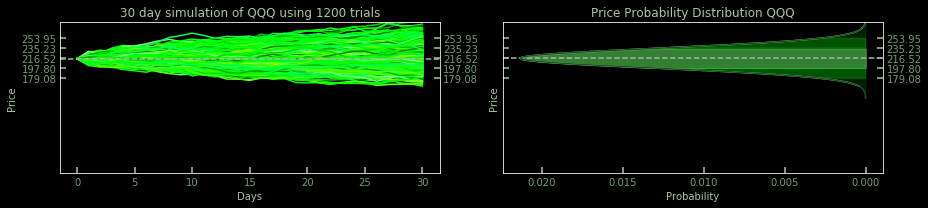

In [12]:
#Get data from user, exit if exit code given
ticker = input("Enter ticker to simulate or 'ENTER' to exit: ").upper()

#get time data
now = dt.datetime.now()
days_backward = int(input("How many days in the past to collect data?: "))
days_forward = int(input("How many days forward to simulate data?: "))
num_sims = int(input("How many simulations to run?: "))
start_date = now - timedelta(days=days_backward)

price_frame = get_dataframe(ticker, start_date, now)
monte_carlo_chart(price_frame, days_forward, num_sims, ticker)